### imports

In [1]:
import lightning as L
import numpy as np
import torch
import torch.nn.functional as F
from minerva.data.datasets.supervised_dataset import SupervisedReconstructionDataset
# from minerva.data.readers.png_reader import PNGReader
# from minerva.data.readers.tiff_reader import TiffReader
# from minerva.data.readers.reader import _Reader
from minerva.models.nets.image.segment_anything.sam_lora import SAMLoRA
from minerva.transforms.transform import _Transform
from minerva.pipelines.lightning_pipeline import SimpleLightningPipeline
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from pathlib import Path
import os
import random
import cv2
from patchify import patchify
from einops import repeat

/usr/local/lib/python3.10/dist-packages/_distutils_hack/__init__.py:54: UserWarning: Reliance on distutils from stdlib is deprecated. Users must rely on setuptools to provide the distutils module. Avoid importing distutils or import setuptools first, and avoid setting SETUPTOOLS_USE_DISTUTILS=stdlib. Register concerns at https://github.com/pypa/setuptools/issues/new?template=distutils-deprecation.yml
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# seed = 42
# random.seed(seed)
# np.random.seed(seed)
# torch.manual_seed(seed)

### Datasets e weights do modelo

In [3]:
#f3 - npy
train_seismic = np.load(os.path.join("/workspaces/Minerva-Discovery/shared_data/data_filipe/f3_in_npy/train/train_seismic.npy"))
train_labels = np.load(os.path.join("/workspaces/Minerva-Discovery/shared_data/data_filipe/f3_in_npy/train/train_labels.npy"))
test_seismic = np.load(os.path.join("/workspaces/Minerva-Discovery/shared_data/data_filipe/f3_in_npy/test_once/test1_seismic.npy"))
test_labels = np.load(os.path.join("/workspaces/Minerva-Discovery/shared_data/data_filipe/f3_in_npy/test_once/test1_labels.npy"))

# f3 - minerva
# train_path = "/workspaces/Minerva-Dev-Container/shared_data/seismic/f3_segmentation/images"
# annotation_path = "/workspaces/Minerva-Dev-Container/shared_data/seismic/f3_segmentation/annotations"

# seam-ai (parihaka)
# train_path = "/workspaces/Minerva-Dev-Container/shared_data/seam_ai_datasets/seam_ai/images"
# annotation_path = "/workspaces/Minerva-Dev-Container/shared_data/seam_ai_datasets/seam_ai/annotations"

checkpoint_path = "/workspaces/Minerva-Discovery/shared_data/weights_sam/checkpoints_sam/sam_vit_b_01ec64.pth"

### classe que lê arquivo npy e cria os patchs (aplica diretamente o transform)

In [4]:
class npyReader():
    def __init__(self, train_seismic, train_labels, patch_size=512, step=512):
        self.images = np.concatenate((
            self._cria_patchs_sismicas_inline(train_seismic, patch_size=(patch_size, patch_size), step=step), 
            self._cria_patchs_sismicas_crossline(train_seismic, patch_size=(patch_size, patch_size), step=step)
        ), axis=0)
        
        self.masks = np.concatenate((
            self._cria_patchs_labels_inline(train_labels, patch_size=(patch_size, patch_size), step=step), 
            self._cria_patchs_labels_crossline(train_labels, patch_size=(patch_size, patch_size), step=step)
        ), axis=0)

    def _rotate_and_flip_patch(self, patch):
        # Rotaciona -90 graus (equivalente a transpor e depois inverter verticalmente)
        patch_rotated = cv2.rotate(patch, cv2.ROTATE_90_CLOCKWISE)
        # Espelha horizontalmente
        patch_flipped = cv2.flip(patch_rotated, 1)
        return patch_flipped
    
    def _resize_image(self, image, target_shape):
        return cv2.resize(image, target_shape, interpolation=cv2.INTER_LINEAR)

    def _cria_patchs_sismicas_crossline(self, images, patch_size=(256,256), step=256):
        all_img_patches = []
        for crossline_idx in range(images.shape[1]): # iterando no crossline
            large_image = images[:, crossline_idx, :]
            target_shape = ((large_image.shape[1] // patch_size[1] + 1) * patch_size[1],
                            (large_image.shape[0] // patch_size[0] + 1) * patch_size[0])
            large_image_resized = self._resize_image(large_image, target_shape)

            patches_img = patchify(large_image_resized, patch_size=patch_size, step=step)  #Step=256 for 256 patches means no overlap

            for i in range(patches_img.shape[0]):
                for j in range(patches_img.shape[1]):
                    single_patch_img = patches_img[i,j,:,:]
                    single_patch_img = self._rotate_and_flip_patch(single_patch_img) # Aplica a rotação e espelhamento
                    all_img_patches.append(single_patch_img)
        return np.array(all_img_patches)

    def _cria_patchs_sismicas_inline(self, images, patch_size=(256,256), step=256):
        all_img_patches = []
        for inline_idx in range(images.shape[0]): # iterando no inline
            large_image = images[inline_idx, :, :]
            target_shape = ((large_image.shape[1] // patch_size[1] + 1) * patch_size[1],
                            (large_image.shape[0] // patch_size[0] + 1) * patch_size[0])
            large_image_resized = self._resize_image(large_image, target_shape)

            patches_img = patchify(large_image_resized, patch_size=patch_size, step=step)  #Step=256 for 256 patches means no overlap

            for i in range(patches_img.shape[0]):
                for j in range(patches_img.shape[1]):
                    single_patch_img = patches_img[i,j,:,:]
                    single_patch_img = self._rotate_and_flip_patch(single_patch_img) # Aplica a rotação e espelhamento
                    all_img_patches.append(single_patch_img)
        return np.array(all_img_patches)

    def _cria_patchs_labels_crossline(self, images_labels, patch_size=(256,256), step=256):
        all_mask_patches = []
        for crossline_idx in range(images_labels.shape[1]): # iterando no crossline
            large_mask = images_labels[:, crossline_idx, :]
            target_shape = ((large_mask.shape[1] // patch_size[1] + 1) * patch_size[1],
                            (large_mask.shape[0] // patch_size[0] + 1) * patch_size[0])
            large_mask_resized = self._resize_image(large_mask, target_shape)

            patches_mask = patchify(large_mask_resized, patch_size=patch_size, step=step)  #Step=256 for 256 patches means no overlap

            for i in range(patches_mask.shape[0]):
                for j in range(patches_mask.shape[1]):
                    single_patch_mask = patches_mask[i,j,:,:]
                    single_patch_mask = self._rotate_and_flip_patch(single_patch_mask) # Aplica a rotação e espelhamento
                    all_mask_patches.append(single_patch_mask)
        return np.array(all_mask_patches)

    def _cria_patchs_labels_inline(self, images_labels, patch_size=(256,256), step=256):
        all_mask_patches = []
        for inline_idx in range(images_labels.shape[0]): # iterando no inline
            large_mask = images_labels[inline_idx, :, :]
            target_shape = ((large_mask.shape[1] // patch_size[1] + 1) * patch_size[1],
                            (large_mask.shape[0] // patch_size[0] + 1) * patch_size[0])
            large_mask_resized = self._resize_image(large_mask, target_shape)

            patches_mask = patchify(large_mask_resized, patch_size=patch_size, step=step)  #Step=256 for 256 patches means no overlap

            for i in range(patches_mask.shape[0]):
                for j in range(patches_mask.shape[1]):
                    single_patch_mask = patches_mask[i,j,:,:]
                    single_patch_mask = self._rotate_and_flip_patch(single_patch_mask) # Aplica a rotação e espelhamento
                    all_mask_patches.append(single_patch_mask)
        return np.array(all_mask_patches)

### alguns transforms

In [ ]:
# class Padding(_Transform):
#     def __init__(self, target_h_size: int, target_w_size: int):
#         self.target_h_size = target_h_size
#         self.target_w_size = target_w_size

#     def __call__(self, x: np.ndarray) -> np.ndarray:
#         h, w = x.shape[:2]
#         pad_h = max(0, self.target_h_size - h)
#         pad_w = max(0, self.target_w_size - w)
#         if len(x.shape) == 2:
#             padded = np.pad(x, ((0, pad_h), (0, pad_w)), mode="reflect")
#             padded = np.expand_dims(padded, axis=2)
#             padded = torch.from_numpy(padded).float()
#         else:
#             padded = np.pad(x, ((0, pad_h), (0, pad_w), (0, 0)), mode="reflect")
#             padded = torch.from_numpy(padded).float()

#         padded = np.transpose(padded, (2, 0, 1))
#         return padded

# class Padding(_Transform):
#     def __init__(self, target_h_size: int, target_w_size: int):
#         self.target_h_size = target_h_size
#         self.target_w_size = target_w_size

#     def __call__(self, x: np.ndarray) -> np.ndarray:
#         h, w = x.shape[:2]
#         pad_h = max(0, self.target_h_size - h)
#         pad_w = max(0, self.target_w_size - w)

#         # Pad the image
#         if len(x.shape) == 2:  # 2D image (grayscale)
#             padded = np.pad(x, ((0, pad_h), (0, pad_w)), mode="reflect")
#             padded = np.expand_dims(padded, axis=2)  # Add channel dimension
#         else:  # 3D image (color)
#             padded = np.pad(x, ((0, pad_h), (0, pad_w), (0, 0)), mode="reflect")

#         # Convert to tensor and ensure shape is (C, H, W)
#         padded = torch.from_numpy(padded).float()

#         # Transpose to (C, H, W) format
#         padded = padded.permute(2, 0, 1) if len(padded.shape) == 3 else padded.unsqueeze(0)

#         # Ensure output size is (C, target_h_size, target_w_size)
#         padded = F.pad(padded, (0, self.target_w_size - padded.shape[2], 0, self.target_h_size - padded.shape[1]), "reflect")

#         return padded

# transform = Padding(512, 512)

from scipy.ndimage.interpolation import zoom

class RandomGeneratorForImage(_Transform):
    def __init__(self, output_size):
        self.output_size = output_size
        
    def __call__(self, image: np.ndarray) -> np.ndarray:
        x, y = image.shape
        if x != self.output_size[0] or y != self.output_size[1]:
            image = zoom(image, (self.output_size[0] / x, self.output_size[1] / y), order=3)
        image = torch.from_numpy(image.astype(np.float32)).unsqueeze(0)
        image = repeat(image, 'c h w -> (repeat c) h w', repeat=3)
        
        return image

class RandomGeneratorForLabel(_Transform):
    def __init__(self, output_size):
        self.output_size = output_size

    def __call__(self, label: np.ndarray) -> np.ndarray:
        x, y = label.shape
        if x != self.output_size[0] or y != self.output_size[1]:
            label = zoom(label, (self.output_size[0] / x, self.output_size[1] / y), order=0)
        label = torch.from_numpy(label.astype(np.float32))
        return label.long()

transformImage = RandomGeneratorForImage((512, 512))
transformLabel = RandomGeneratorForLabel((512, 512))

/tmp/ipykernel_272669/1535008015.py:51: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  from scipy.ndimage.interpolation import zoom


### criando módulo que criar dataset e dataloader

In [6]:
class F3DataModule(L.LightningDataModule):
    def __init__(
        self,
        train_seismic,
        train_labels,
        test_seismic,
        test_labels,
        patch_size: int = 512,
        step: int = 512,
        transforms: _Transform = None,
        batch_size: int = 1,
        num_workers: int = None,
    ):
        super().__init__()
        self.train_seismic = train_seismic
        self.train_labels = train_labels
        self.test_seismic = test_seismic
        self.test_labels = test_labels
        self.patch_size = patch_size
        self.step = step
        self.transforms = transforms
        self.batch_size = batch_size
        self.num_workers = (
            num_workers if num_workers is not None else os.cpu_count()
        )

        self.datasets = {}

    def setup(self, stage=None):
        if stage == "fit":
            npy_files = npyReader(
                train_seismic=self.train_seismic, 
                train_labels=self.train_labels, 
                patch_size=self.patch_size, 
                step=self.step
            )
            train_imgs = npy_files.images
            train_labels = npy_files.masks

            # Dividir 80/20 para treino e validação
            num_train_samples = int(len(train_imgs) * 0.8)
            indices = list(range(len(train_imgs)))
            random.shuffle(indices)
            train_indices = indices[:num_train_samples]
            val_indices = indices[num_train_samples:]

            train_img_reader = [train_imgs[i] for i in train_indices]
            train_label_reader = [train_labels[i] for i in train_indices]
            val_img_reader = [train_imgs[i] for i in val_indices]
            val_label_reader = [train_labels[i] for i in val_indices]

            train_dataset = SupervisedReconstructionDataset(
                readers=[train_img_reader, train_label_reader],
                transforms=self.transforms,
            )

            val_dataset = SupervisedReconstructionDataset(
                readers=[val_img_reader, val_label_reader],
                transforms=self.transforms,
            )

            self.datasets["train"] = train_dataset
            self.datasets["val"] = val_dataset

        elif stage == "test" or stage == "predict":
            npy_files = npyReader(
                train_seismic=self.test_seismic, 
                train_labels=self.test_labels, 
                patch_size=self.patch_size, 
                step=self.step
            )
            test_imgs = npy_files.images
            test_labels = npy_files.masks

            test_dataset = SupervisedReconstructionDataset(
                readers=[test_imgs, test_labels],
                transforms=self.transforms,
            )
            self.datasets["test"] = test_dataset
            self.datasets["predict"] = test_dataset

        else:
            raise ValueError(f"Invalid stage: {stage}")

    def train_dataloader(self):
        return DataLoader(
            self.datasets["train"],
            batch_size=self.batch_size,
            persistent_workers=True,
            num_workers=self.num_workers,
            shuffle=True,
            pin_memory=True, 
            worker_init_fn=self.worker_init_fn,
            drop_last=False
        )

    def val_dataloader(self):
        return DataLoader(
            self.datasets["val"],
            batch_size=self.batch_size,
            persistent_workers=True,
            num_workers=self.num_workers,
            shuffle=False,
            pin_memory=True, 
            worker_init_fn=self.worker_init_fn,
            drop_last=False
        )

    def test_dataloader(self):
        return DataLoader(
            self.datasets["test"],
            batch_size=self.batch_size,
            persistent_workers=True,
            num_workers=self.num_workers,
            shuffle=False,
            pin_memory=True, 
            worker_init_fn=self.worker_init_fn,
            drop_last=False
        )

    def predict_dataloader(self):
        return DataLoader(
            self.datasets["predict"],
            batch_size=self.batch_size,
            persistent_workers=True,
            num_workers=self.num_workers,
            shuffle=False,
            pin_memory=True, 
            worker_init_fn=self.worker_init_fn,
            drop_last=False
        )
    def worker_init_fn(self, worker_id):
        random.seed(18 + worker_id)

data_module = F3DataModule(
    train_seismic=train_seismic,
    train_labels=train_labels,
    test_seismic=test_seismic,
    test_labels=test_labels,
    patch_size=512,
    step=512,
    transforms=[transformImage, transformLabel],
    batch_size=7,
)

### Teste para visualizar imagens no batch

301 <class 'torch.utils.data.dataloader.DataLoader'>


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image shape: torch.Size([4, 3, 512, 512])
Label shape: torch.Size([4, 512, 512])
Image shape: torch.Size([4, 3, 512, 512])
Label shape: torch.Size([4, 512, 512])


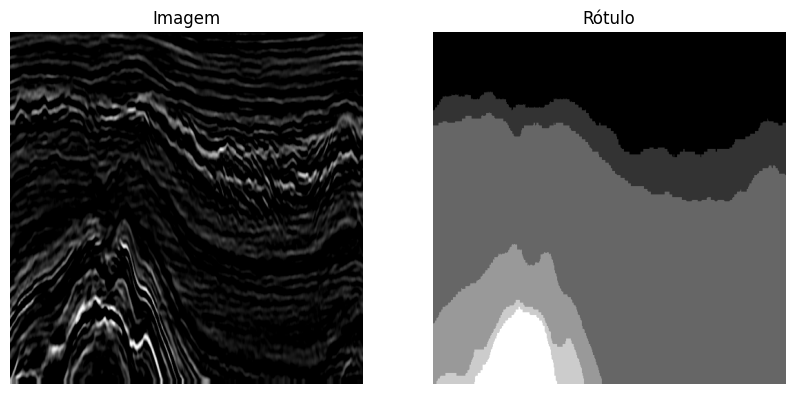

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


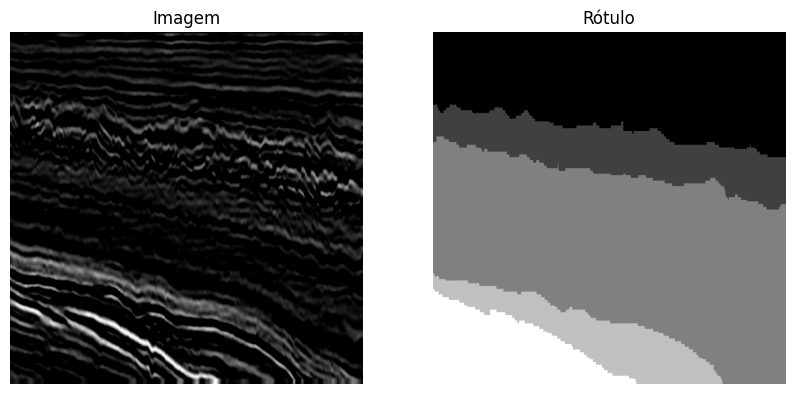

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


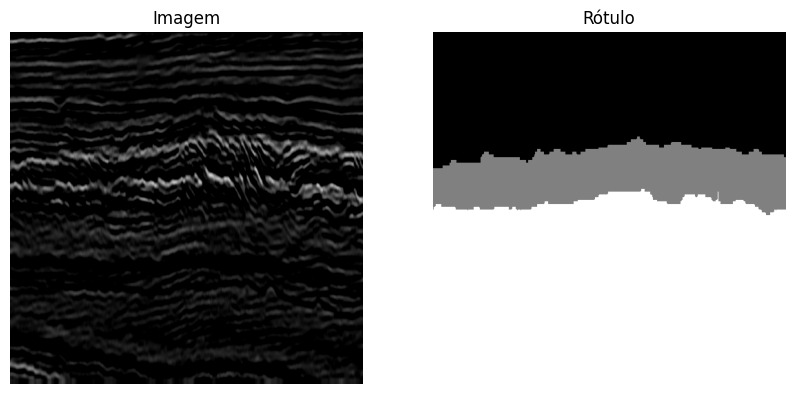

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


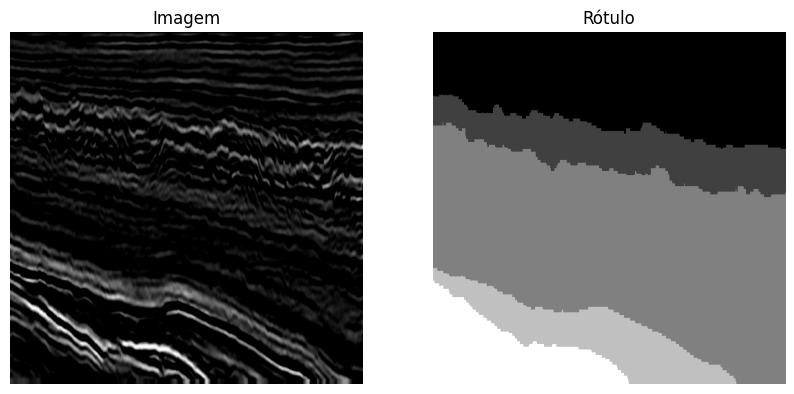

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


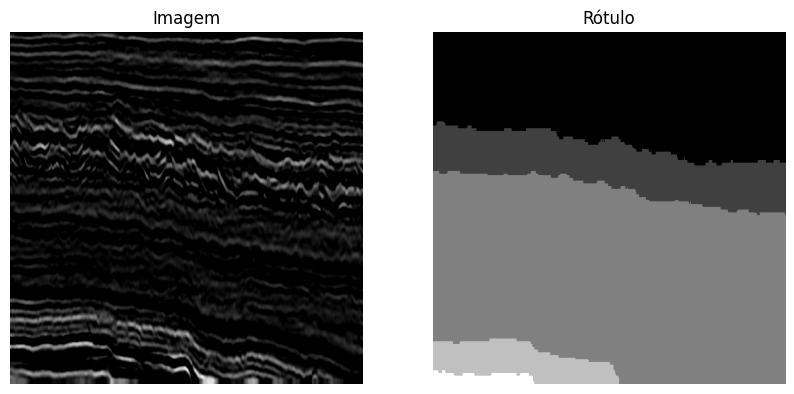

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


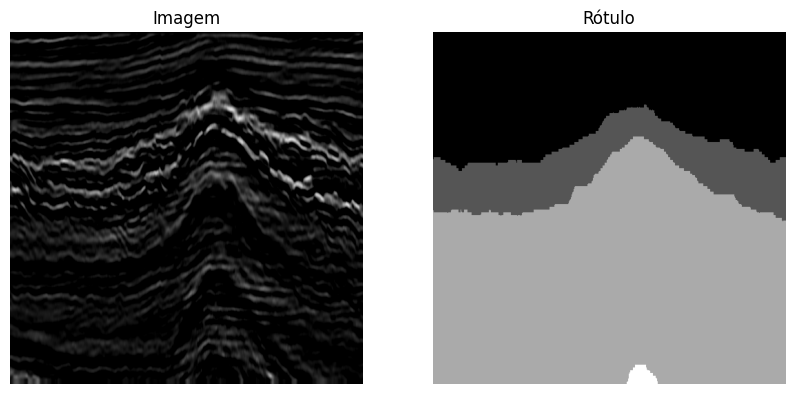

In [7]:
# Configura o DataModule para o estágio de treinamento
data_module.setup(stage='fit')

# Obtenha o DataLoader para os dados de treinamento
train_loader = data_module.train_dataloader()
print(len(train_loader), type(train_loader))

# Define o número de amostras que queremos exibir
num_amostras = 6
amostras = []

# Itera pelos batches para coletar as amostras
for batch in train_loader:
    image, label = batch
    print("Image shape:", image.shape)  # Esperado: torch.Size([4, 3, 512, 512])
    print("Label shape:", label.shape)  # Esperado: torch.Size([4, 512, 512])
    
    # Converte a imagem para numpy e ajusta para HWC
    image_np = image.permute(0, 2, 3, 1).detach().cpu().numpy()  # (batch, height, width, channels)
    label_np = label.detach().cpu().numpy()  # Sem permutação, pois já está em formato HW

    # Normaliza a imagem se necessário
    if image_np.max() > 1:
        image_np = image_np / 255.0

    # Adiciona cada imagem e rótulo ao conjunto de amostras até atingir o número desejado
    for i in range(image_np.shape[0]):
        amostras.append((image_np[i], label_np[i]))  # Sem remover o canal extra da imagem colorida
        if len(amostras) >= num_amostras:
            break
    if len(amostras) >= num_amostras:
        break

# Plota as amostras em uma grade 3x2
for idx, (img, lbl) in enumerate(amostras):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    # Plota a imagem
    axs[0].imshow(img)
    axs[0].set_title("Imagem")
    axs[0].axis('off')

    # Plota o rótulo
    axs[1].imshow(lbl, cmap='gray')
    axs[1].set_title("Rótulo")
    axs[1].axis('off')

    plt.show()

### instancia o modelo

In [7]:
model = SAMLoRA(
    image_size=512,
    num_classes=5, # considera 6 pois internamente o sam faz +1 pro background
    # pixel_mean=pixel_mean,
    # pixel_std=pixel_std,
    alpha=1,
    rank=4,
    # apply_lora_vision_encoder=False,
    # apply_lora_mask_decoder=False,
    # frozen_vision_encoder=False,
    # frozen_prompt_encoder=True,
    # frozen_mask_decoder=False,
    # vit_model=vit_model,
    checkpoint=checkpoint_path,
    # train_metrics={"mIoU": JaccardIndex(task="multiclass", num_classes=6)},
    # val_metrics={"mIoU": JaccardIndex(task="multiclass", num_classes=6)},
    # test_metrics={"mIoU": JaccardIndex(task="multiclass", num_classes=6)},
)

/home/vscode/.local/lib/python3.10/site-packages/minerva/models/nets/image/segment_anything/build_sam.py:131: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torc

In [8]:
from lightning.pytorch.loggers import TensorBoardLogger
# Defina o logger do TensorBoard
logger = TensorBoardLogger("logs", name="sam_model")

trainer = L.Trainer(
    max_epochs=50,
    accelerator="gpu",
    devices=1,
    logger=logger
)
# trainer.fit(model, data_module)

pipeline = SimpleLightningPipeline(
    model=model,
    trainer=trainer,
    save_run_status=True
)

pipeline.run(data=data_module, task="fit")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Log directory set to: /workspaces/Minerva-Discovery/my_experiments/sam_v1/notebooks/logs/sam_model/version_8


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | ce_loss   | CrossEntropyLoss | 0      | train
1 | dice_loss | DiceLoss         | 0      | train
2 | model     | Sam              | 91.8 M | train
-------------------------------------------------------
191 K     Trainable params
91.6 M    Non-trainable params
91.8 M    Total params
367.260   Total estimated model params size (MB)
310       Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 172/172 [00:34<00:00,  4.92it/s, v_num=8, train_loss_step=0.539, val_loss_step=0.526, val_pixel_accuracy=0.765, val_mean_class_accuracy=0.493, val_dice_score=0.765, val_mIoU=0.368, val_loss_epoch=0.505, train_pixel_accuracy=0.982, train_mean_class_accuracy=0.972, train_dice_score=0.982, train_mIoU=0.944, train_loss_epoch=0.125]    

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 172/172 [00:35<00:00,  4.80it/s, v_num=8, train_loss_step=0.539, val_loss_step=0.526, val_pixel_accuracy=0.765, val_mean_class_accuracy=0.493, val_dice_score=0.765, val_mIoU=0.368, val_loss_epoch=0.505, train_pixel_accuracy=0.982, train_mean_class_accuracy=0.972, train_dice_score=0.982, train_mIoU=0.944, train_loss_epoch=0.125]
Pipeline info saved at: /workspaces/Minerva-Discovery/my_experiments/sam_v1/notebooks/logs/sam_model/version_8/run_2024-11-08-22-37-028704ee16aa8943ebb170ae66a8d9b87e.yaml


In [11]:
# !tensorboard --logdir logs/

In [9]:
# trainer.test(model, data_module)
pipeline.run(data=data_module, task="test")

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 158/158 [00:13<00:00, 12.05it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_dice_score      │    0.5930324196815491     │
│      test_loss_epoch      │     0.691034197807312     │
│         test_mIoU         │    0.28310060501098633    │
│ test_mean_class_accuracy  │    0.4042151868343353     │
│    test_pixel_accuracy    │    0.5930324196815491     │
└───────────────────────────┴───────────────────────────┘

Pipeline info saved at: /workspaces/Minerva-Discovery/my_experiments/sam_v1/notebooks/logs/sam_model/version_8/run_2024-11-08-22-37-028704ee16aa8943ebb170ae66a8d9b87e.yaml


[{'test_pixel_accuracy': 0.5930324196815491,
  'test_mean_class_accuracy': 0.4042151868343353,
  'test_dice_score': 0.5930324196815491,
  'test_mIoU': 0.28310060501098633,
  'test_loss_epoch': 0.691034197807312}]

In [10]:
# preds = trainer.predict(model, data_module)
preds = pipeline.run(data=data_module, task="predict")

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 158/158 [00:13<00:00, 11.72it/s]
Pipeline info saved at: /workspaces/Minerva-Discovery/my_experiments/sam_v1/notebooks/logs/sam_model/version_3/run_2024-11-08-14-02-571faf4798856844c7aafa55d241e7f72f.yaml


In [11]:
image = torch.argmax(preds[108]['masks'], dim=1)

In [12]:
from matplotlib.colors import ListedColormap
label_cmap = ListedColormap(
    [
        [0.29411764705882354, 0.4392156862745098, 0.7333333333333333],
        [0.5882352941176471, 0.7607843137254902, 0.8666666666666667],
        [0.8901960784313725, 0.9647058823529412, 0.9764705882352941],
        [0.9803921568627451, 0.8745098039215686, 0.4666666666666667],
        [0.9607843137254902, 0.47058823529411764, 0.29411764705882354],
        [0.8470588235294118, 0.1568627450980392, 0.1411764705882353],
    ]
)

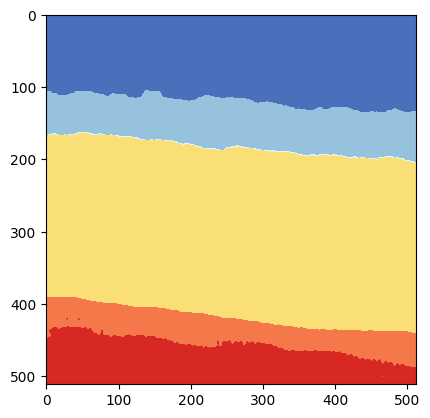

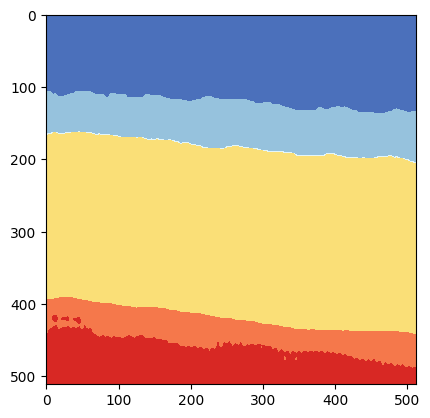

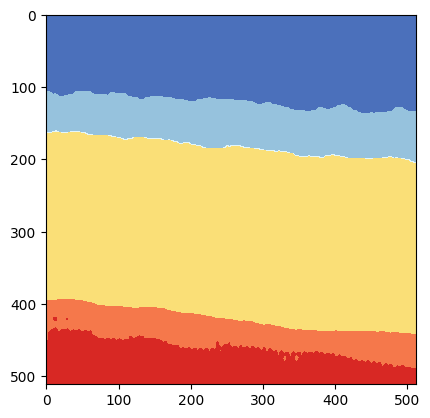

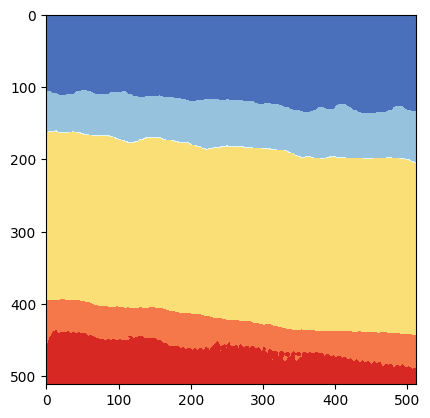

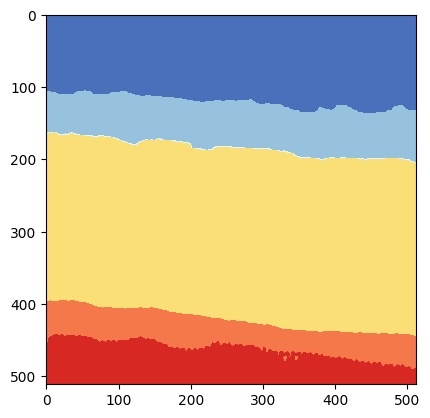

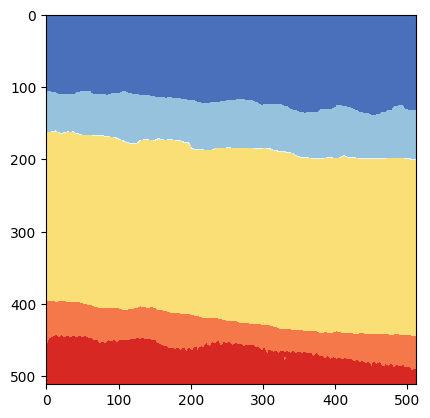

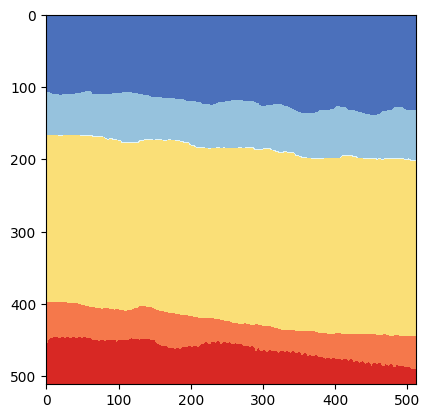

In [13]:
for i, img in enumerate(image):
    plt.imshow(img.squeeze().numpy(), cmap=label_cmap)
    plt.show()